## Libraries required to Build the Models

In [1]:
import pandas as pd
import numpy as np
import streamlit as st
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
import scipy.stats as stats
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.linear_model import LinearRegression
#from sklearn.logistic_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_curve


## Below will set the max line views

In [2]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)

## Important points to be noted while building the model

In [3]:
# Success and LOST being considered as Failure and remove data points other than WON, LOST STATUS values.

# 1) Exploring skewness and outliers in the dataset.
# 2) Transform the data into a suitable format and perform any necessary cleaning
# and pre-processing steps.
# 3) ML Regression model which predicts continuous variable ‘Selling_Price’.
# 4) ML Classification model which predicts Status: WON or LOST.
# 5) Creating a streamlit page where you can insert each column value and you will
# get the Selling_Price predicted value or Status(Won/Lost)

#  ‘Material_Reference’
# which starts with ‘00000’ value which should be converted into null. Treat
# reference columns as categorical variables

# check for building pipeline

## Reading the Copper Modeling Data

In [4]:
df = pd.read_excel(r"F:/data science/Project/5. Industrial Copper Modeling/Copper_Set.xlsx")
df.head()

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.00
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.00
2,E140FF1B-2407-4C02-A0DD-780A093B1158,20210401.0,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,20210101.0,644.33
3,F8D507A0-9C62-4EFE-831E-33E1DA53BB50,20210401.0,202.411065,30349574.0,32.0,Won,S,59.0,2.30,1317.0,DX51D+ZM310MAO 2.3X1317,1668701718,20210101.0,768.00
4,4E1C4E78-152B-430A-8094-ADD889C9D0AD,20210401.0,785.526262,30211560.0,28.0,Won,W,10.0,4.00,2000.0,2_S275JR+AR-CL1,640665,20210301.0,577.00


## Checking its Characteristics     

In [5]:
df.shape

(181673, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


## Checking the Unique values in all columns

In [7]:
for i in list(df.columns):
    print(f"{i}:{df[i].nunique()}")

id:181671
item_date:252
quantity tons:181673
customer:1169
country:17
status:9
item type:7
application:30
thickness:594
width:1386
material_ref:16563
product_ref:33
delivery date:28
selling_price:9795


## Treating Material_ref column as given in requirements

In [8]:
## Checking how many values start with "00000". Which are not are not needed as per requirements so converting to null
df["material_ref"].str.startswith("00000").sum()

22726

In [9]:
## converting values start with "00000" to Nan using Lambda function
df["material_ref"] = df["material_ref"].apply(lambda x: np.nan if str(x).startswith("00000") else x)
## Checking how many values start with "00000" after treating it with Nan values
df["material_ref"].str.startswith("00000").sum()

0

## Datatype conversion

In [10]:
## Converting the datatype of column "quantity tons" to numeric. "errors='coerce'" will populate Nan values if there are any errors
df['quantity tons'] = pd.to_numeric(df['quantity tons'], errors='coerce')
## Datatype conversion for column "quantity tons" to float
df['quantity tons'] = df['quantity tons'].astype(float)
## Datatype conversion for column to umeric. 
df["customer"] = pd.to_numeric(df["customer"],errors='coerce')
df["country"] = pd.to_numeric(df["country"],errors='coerce')
df["application"] = pd.to_numeric(df["application"],errors='coerce')
#df["delivery date"] = df["delivery date"].astype(int)
#df["item_date"] = df["item_date"].astype(int)
df['item_date'] = pd.to_datetime(df['item_date'], format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'], format='%Y%m%d', errors='coerce').dt.date

## Treating Null values in all columns

In [11]:
df.isnull().sum()/len(df)*100

id                0.001101
item_date         0.001651
quantity tons     0.000550
customer          0.000550
country           0.015412
status            0.001101
item type         0.000000
application       0.013211
thickness         0.000550
width             0.000000
material_ref     55.398986
product_ref       0.000000
delivery date     0.001651
selling_price     0.000550
dtype: float64

In [12]:
## Treating the null value with bfill and ffill for column "material_ref" considering it is categorical having null value ebtween 20-80%
df["material_ref"] = df["material_ref"].bfill().ffill()

In [13]:
df.isnull().sum()/len(df)*100

id               0.001101
item_date        0.001651
quantity tons    0.000550
customer         0.000550
country          0.015412
status           0.001101
item type        0.000000
application      0.013211
thickness        0.000550
width            0.000000
material_ref     0.000000
product_ref      0.000000
delivery date    0.001651
selling_price    0.000550
dtype: float64

In [14]:
# Dropping the remaining rows which has very minimal null values in this case
df.dropna(inplace=True)

In [15]:
df.isnull().sum()/len(df)*100

id               0.0
item_date        0.0
quantity tons    0.0
customer         0.0
country          0.0
status           0.0
item type        0.0
application      0.0
thickness        0.0
width            0.0
material_ref     0.0
product_ref      0.0
delivery date    0.0
selling_price    0.0
dtype: float64

In [16]:
df.status.value_counts()

status
Won                116004
Lost                34431
Not lost for AM     19568
Revised              4276
To be approved       4167
Draft                3121
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64

## Treating Inconsistency Data

In [17]:
## Checking for data inconsistency in "quantity tons". 
## shows quantity tons cannot be in negative. but here it is. which may be a wrong data
df[df["quantity tons"] < 0.0]

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
105730,36820BDA-8CDF-49F3-89A2-C50A55B70CEB,2020-11-11,-4.000000,30203192.0,27.0,Won,S,15.0,1.50,1500.0,PR014246,1332077137,2021-01-01,723.0
131473,D03D83BD-3D05-40FB-A71E-6C33CCD06D97,2020-10-02,-1.476794,30199273.0,27.0,Draft,S,10.0,0.60,1220.0,G9002,611993,2021-01-01,22.0
181661,802C8D24-710A-4A96-B3B1-F33F383EC455,2020-07-02,-18.000000,30200854.0,25.0,Won,W,41.0,0.84,1220.0,202006170005.IO.1.1,164141591,2020-07-01,590.0
181671,7AFFD323-01D9-4E15-B80D-7D1B03498FC8,2020-07-02,-2000.000000,30200854.0,25.0,Won,W,41.0,0.85,1250.0,202006170005.IO.1.1,164141591,2020-07-01,601.0


In [18]:
## Checking for data inconsistency in "Selling Price". 
## shows Selling price cannot be in negative. but here it is. which may be a wrong data
df[df["selling_price"] < 0.0]

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
28,BEC18863-E965-478B-9861-A49A77F26655,2021-04-01,99.059199,30153510.0,30.0,Won,W,41.0,0.595,1207.0,GOO1208X595SP,611993,2021-04-01,-1160.0
44761,947C725B-85ED-4817-B4F8-27720314F9E6,2021-02-04,101.397995,30198657.0,32.0,Won,W,41.0,1.250,1100.0,V1041SOL,1721130331,2021-04-01,-730.0
44810,35C64267-229F-438E-9A3B-91A6A41DACE2,2021-02-03,12.225889,30157111.0,78.0,Won,W,41.0,0.750,1250.0,8870-0626-3001500VEN,164141591,2021-04-01,-445.0
44865,87F20C79-CE1E-4325-BBA8-1C6DE4657084,2021-02-03,28.368563,30217604.0,27.0,Not lost for AM,PL,10.0,1.500,1270.0,BOB,164141591,2021-05-01,-25.0
105189,8CA4D51F-DF96-4B88-805D-3937CCFDA810,2020-11-12,5.280274,30209814.0,25.0,Won,W,15.0,6.000,1250.0,84080007932US3ATL,1671863738,2021-02-01,-336.0


In [19]:
## dropping the inconsistent data in quantity tons
df.drop(df[df["quantity tons"] < 0.0].index,axis=0,inplace=True)
## dropping the inconsistent data in selling price
df.drop(df[df["selling_price"] < 0.0].index,axis=0,inplace=True)
# Dropping the column "id" which is notusefull in this selling price prediction
df.drop(["id"],axis=1,inplace=True) 

## Checking for duplicate value to drop

In [20]:
df.duplicated().sum()

0

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity tons,181622.0,5.876532e+03,2.349405e+06,0.00001,1.096878e+01,3.036420e+01,6.716208e+01,1.000000e+09
customer,181622.0,3.023251e+07,1.005646e+05,12458.00000,3.019688e+07,3.020524e+07,3.028042e+07,3.040818e+07
country,181622.0,4.489380e+01,2.440450e+01,25.00000,2.600000e+01,3.000000e+01,7.800000e+01,1.130000e+02
application,181622.0,2.561584e+01,1.775397e+01,2.00000,1.000000e+01,1.500000e+01,4.100000e+01,9.900000e+01
thickness,181622.0,2.564249e+00,6.572786e+00,0.18000,7.000000e-01,1.500000e+00,3.000000e+00,2.500000e+03
width,181622.0,1.295269e+03,2.616494e+02,1.00000,1.180000e+03,1.250000e+03,1.500000e+03,2.990000e+03
product_ref,181622.0,4.740336e+08,7.175428e+08,611728.00000,6.119930e+05,6.406650e+05,1.332077e+09,1.722208e+09
selling_price,181622.0,1.918466e+03,3.318413e+05,0.00000,6.690000e+02,8.120000e+02,9.530000e+02,1.000010e+08


## Finding Outlier and Treating using IQR

In [22]:
def plot(df, column):
    plt.figure(figsize=(20,5))
    plt.subplot(1,3,1)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

    plt.subplot(1,3,2)
    sns.histplot(data=df, x=column, kde=True, bins=50)
    plt.title(f'Distribution Plot for {column}')

    plt.subplot(1,3,3)
    sns.violinplot(data=df, x=column)
    plt.title(f'Violin Plot for {column}')
    plt.show()

Skewness for quantity tons is 424.631201780989


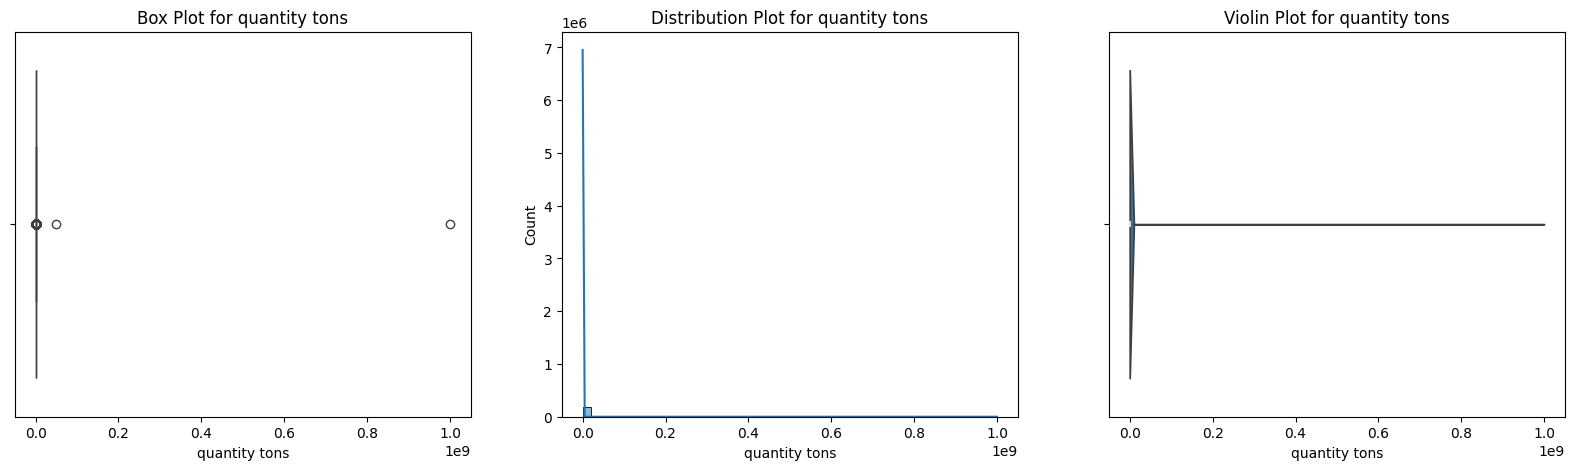

Skewness for customer is -149.08772540132142


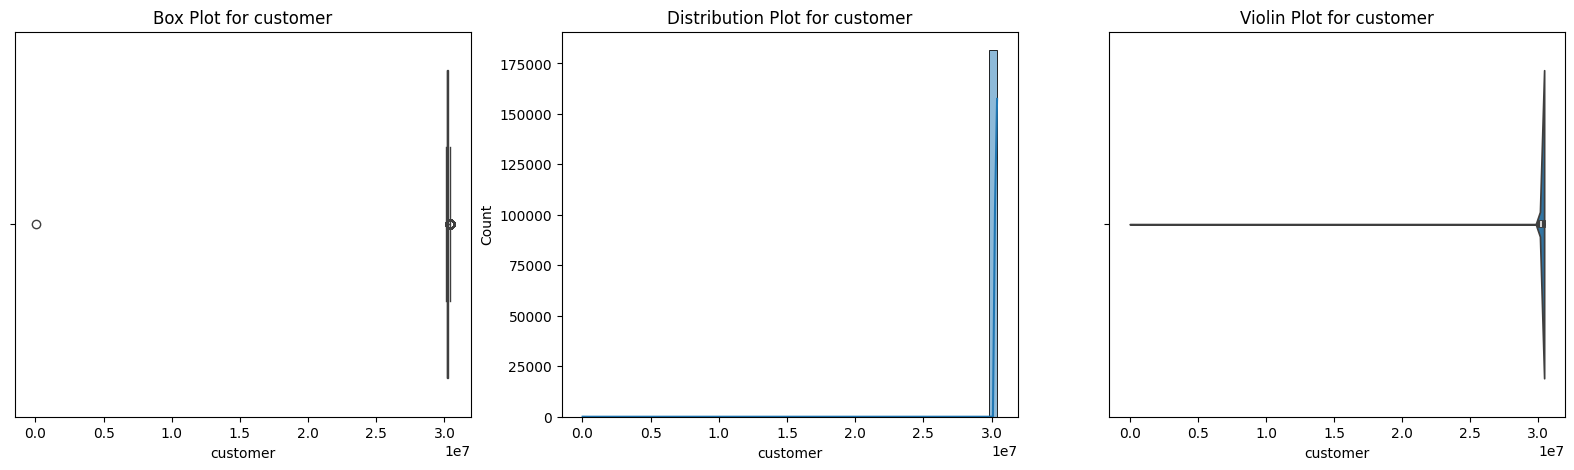

Skewness for country is 0.7535334372171023


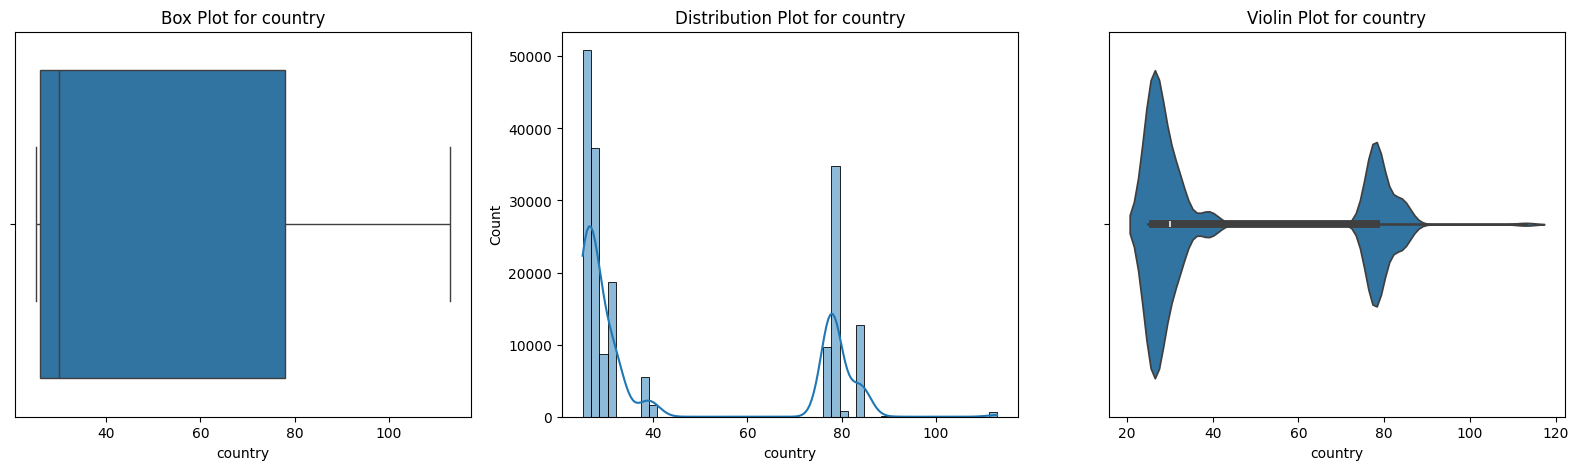

Skewness for application is 0.7243568740042658


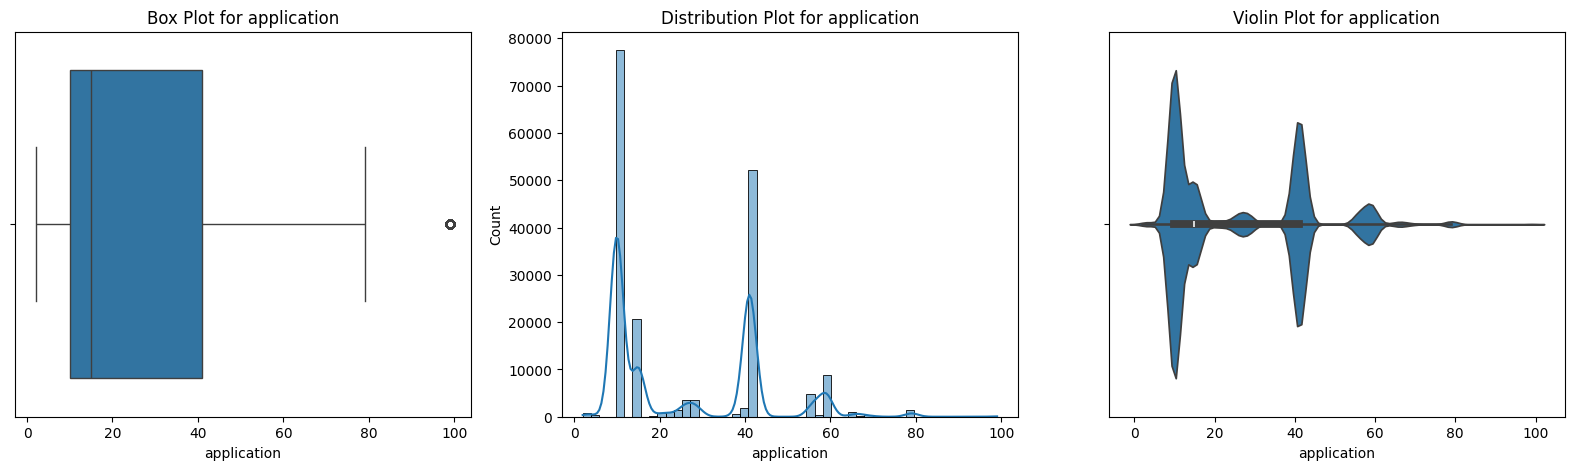

Skewness for thickness is 303.46594893091077


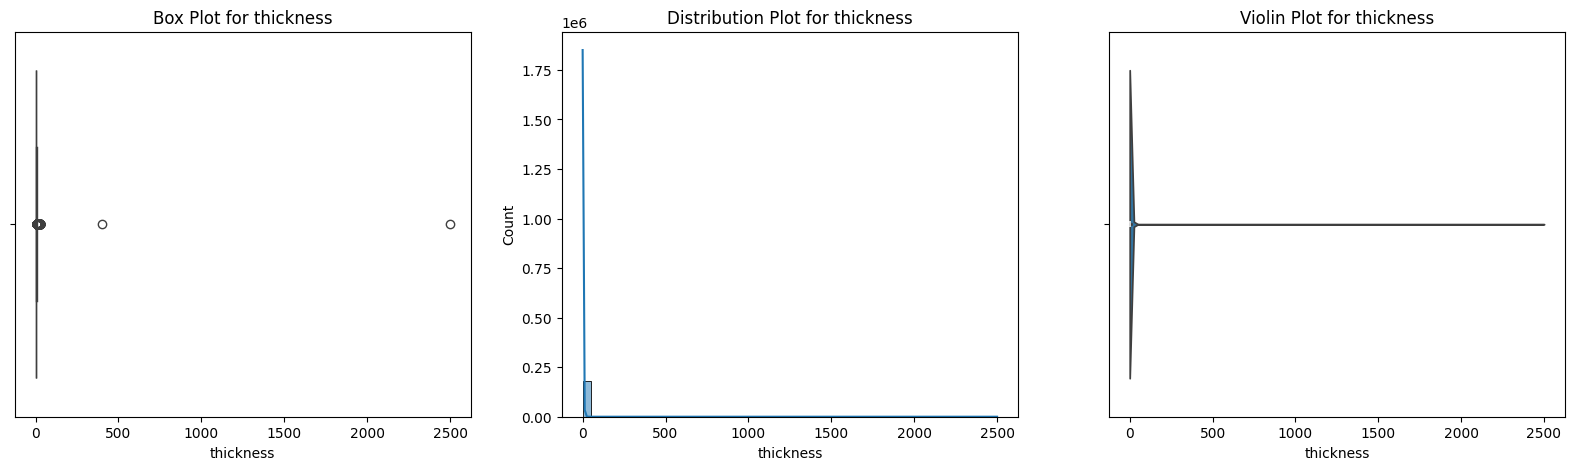

Skewness for width is 0.3748157282325279


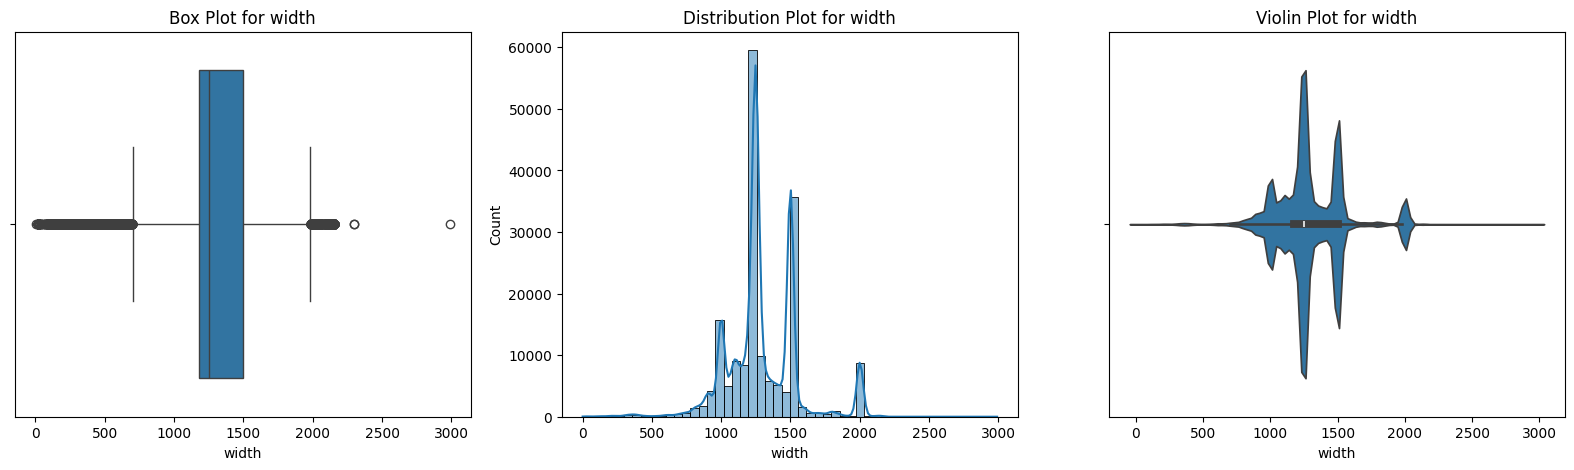

Skewness for product_ref is 1.0149985906494232


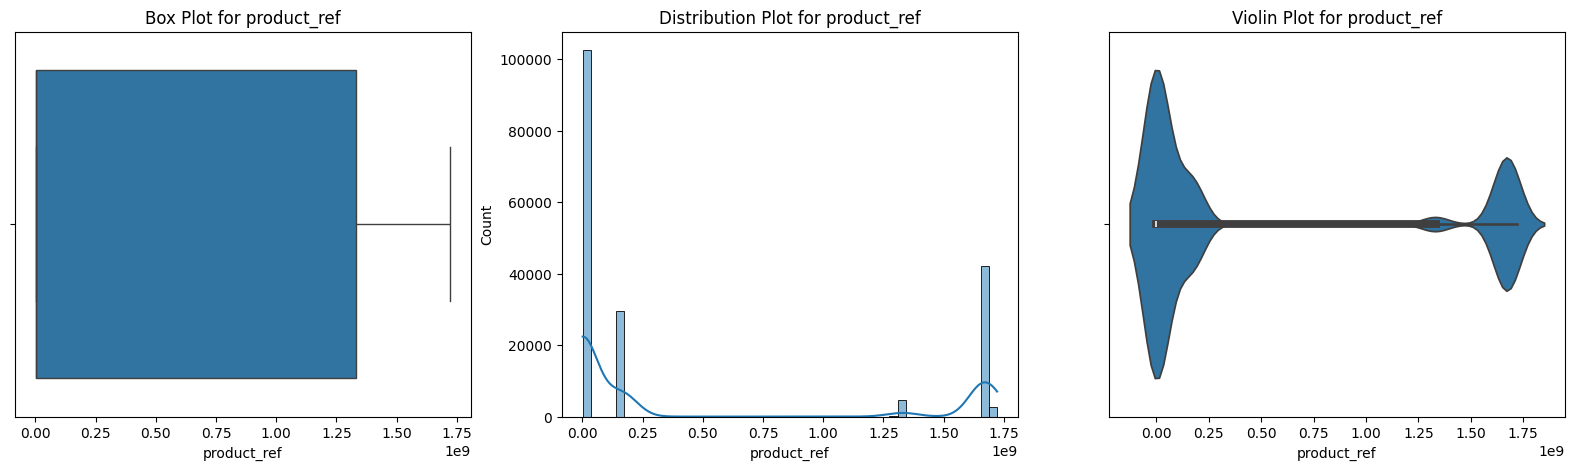

Skewness for selling_price is 301.34578131351685


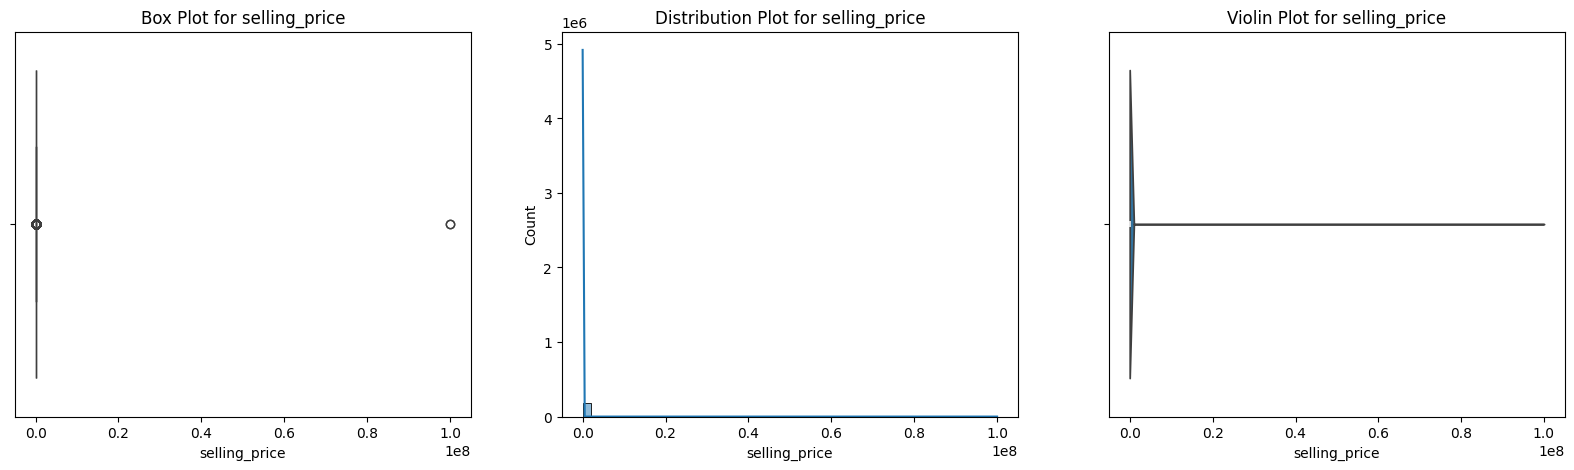

In [23]:
## Below is the check only for numerical data
a = ["quantity tons","customer","country","application","thickness","width","product_ref","selling_price"]


for i in a:
    print(f"Skewness for {i} is {df[i].skew()}")
    plot(df, i)

iqr:  56.1932921117523
-73.321153926112 151.4520145208972
(160673, 13)
Skewness after with treating IRQ:  1.3165134842427495


<Axes: ylabel='quantity tons'>

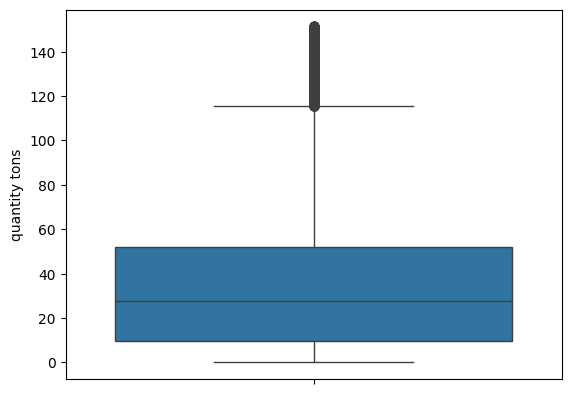

In [24]:
## For reference how to treat outliers with IQR method. but as per requireemnt we need to do log transformation
q1 = df["quantity tons"].quantile(0.25)
q3= df["quantity tons"].quantile(0.75)
iqr = q3-q1
print("iqr: ",iqr)

## Setting upper limit and lower limit

ll = q1 - (1.5*iqr)
ul = q3 + (1.5*iqr)

print(ll, ul)

dfq_iqr = df[~((df["quantity tons"] < ll) | (df["quantity tons"] > ul))]

print(dfq_iqr.shape)

print("Skewness after with treating IRQ: ",dfq_iqr["quantity tons"].skew())

sns.boxplot(dfq_iqr["quantity tons"])

z-score skewness:  424.6312017809885


<Axes: ylabel='ztb_tons'>

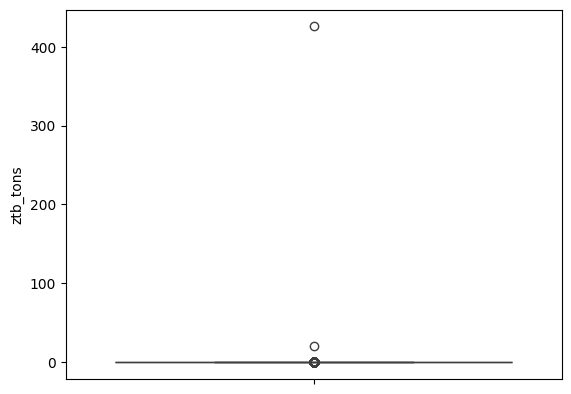

In [25]:
# For reference how to treat outliers with z-score method. but as per requireemnt we need to do log transformation

df["ztb_tons"] = zscore(df["quantity tons"])

print("z-score skewness: ",df["ztb_tons"].skew())
sns.boxplot(df["ztb_tons"])

## Converting the columns to LOG transformation inorder not to loose the data because of outlier treatment

In [26]:
df["log_quantity_tons"] = np.log(df["quantity tons"])
df["log_selling_price"] = np.log(df["selling_price"])
df["log_thickness"] = np.log(df["thickness"])

df.drop(df[df["log_quantity_tons"].isin([-np.inf])].index,axis=0,inplace=True)
df.drop(df[df["log_selling_price"].isin([-np.inf])].index,axis=0,inplace=True)
df.drop(df[df["log_thickness"].isin([-np.inf])].index,axis=0,inplace=True)

f:\data science\VS\DataScience projects\.venv\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skewness for log_quantity_tons is -0.06876995286940332


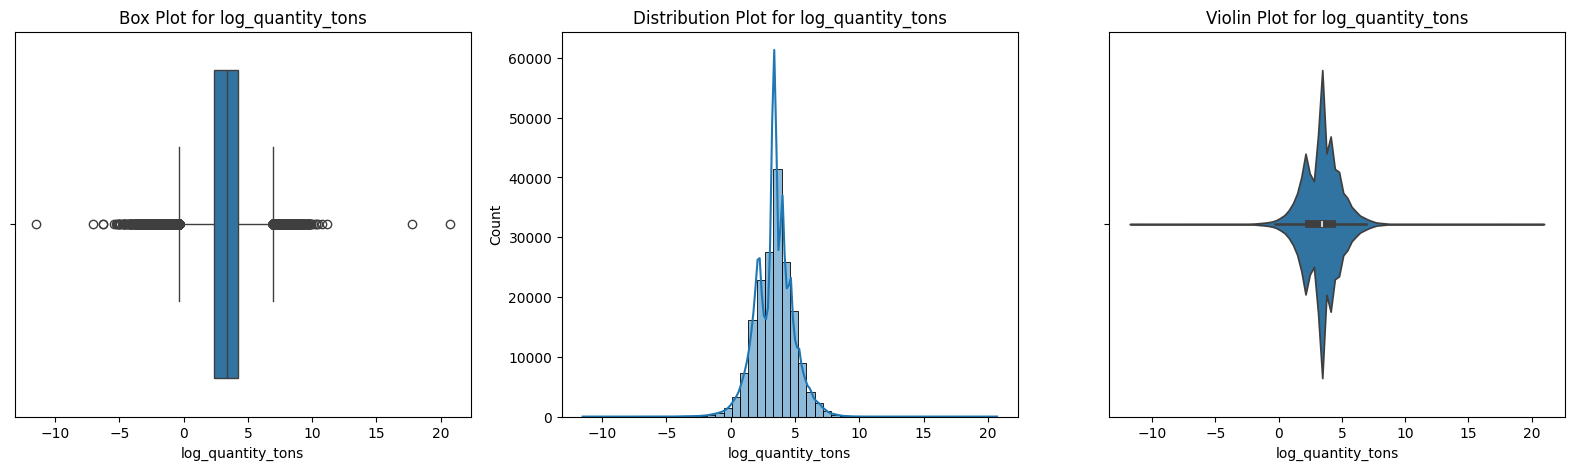

Skewness for customer is -149.0871412256045


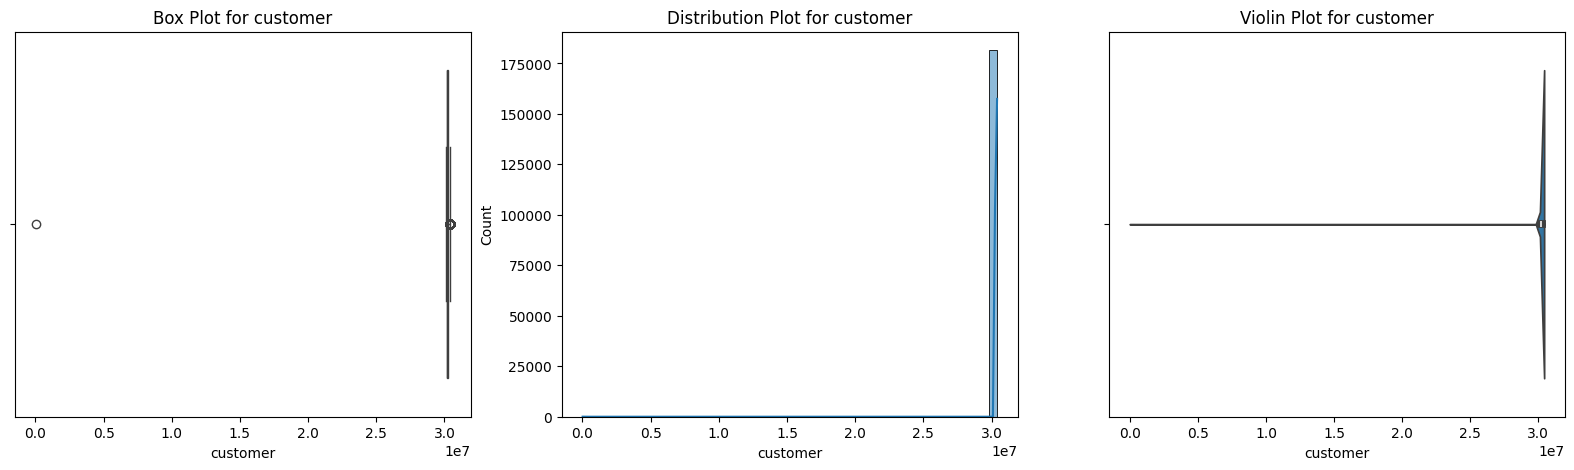

Skewness for country is 0.7535164382634496


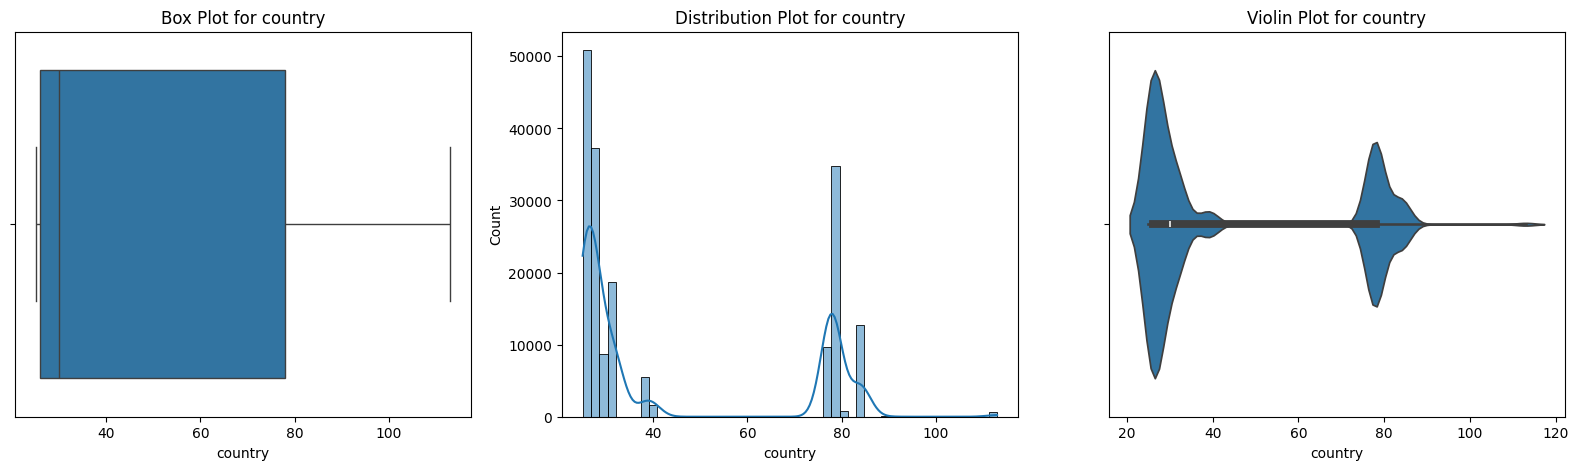

Skewness for application is 0.7243837140276725


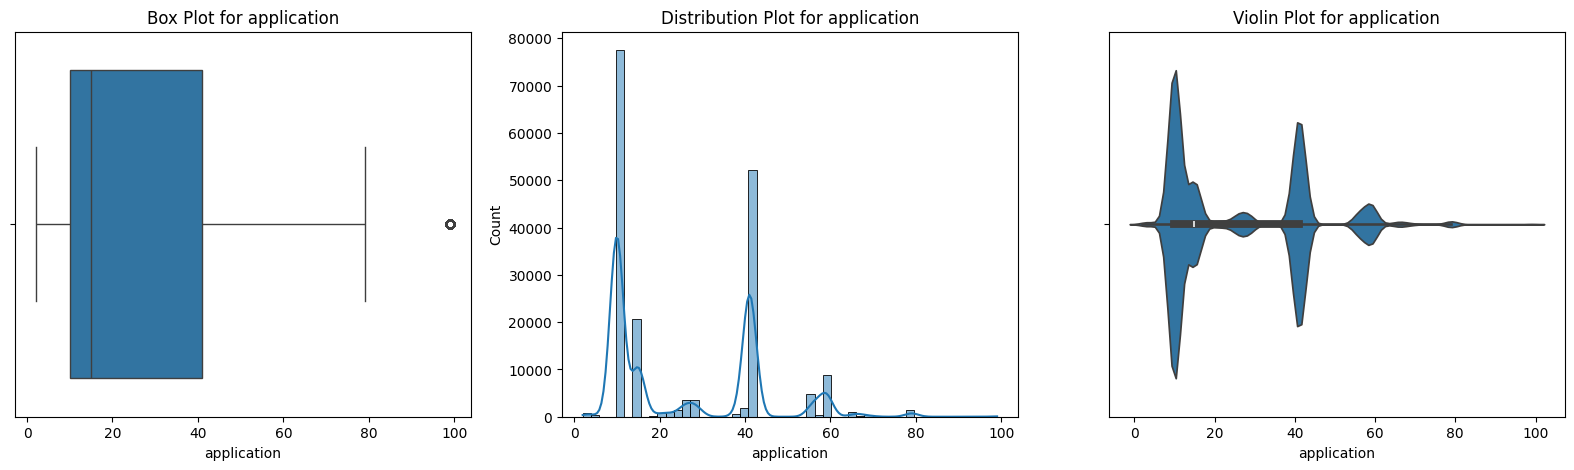

Skewness for log_thickness is 0.3491253164528563


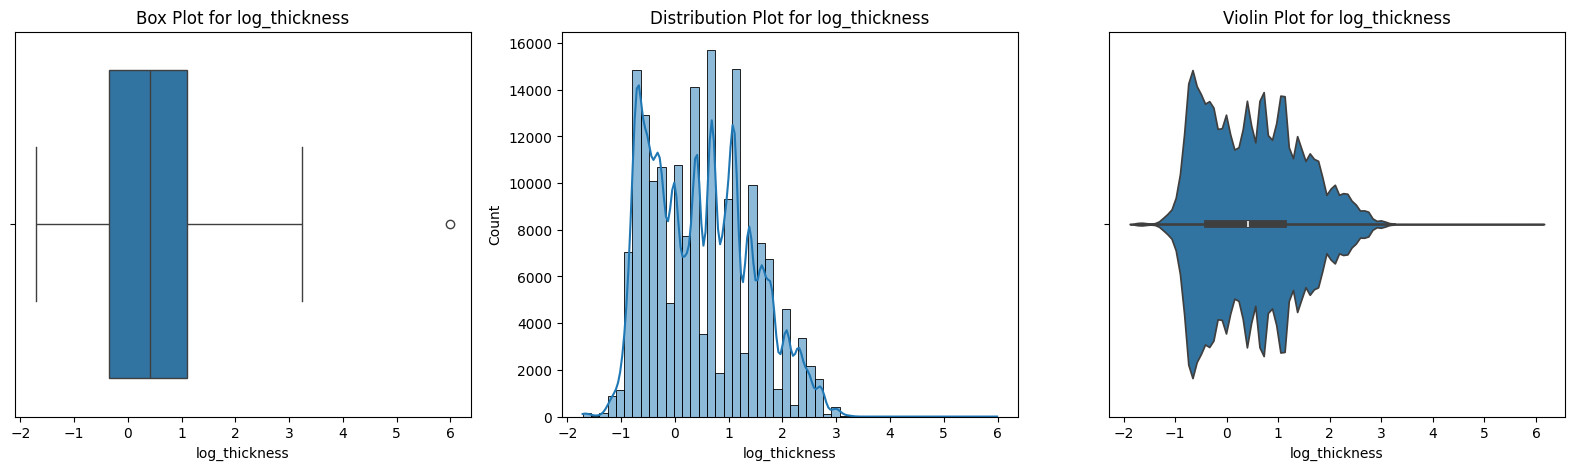

Skewness for width is 0.3748118073364622


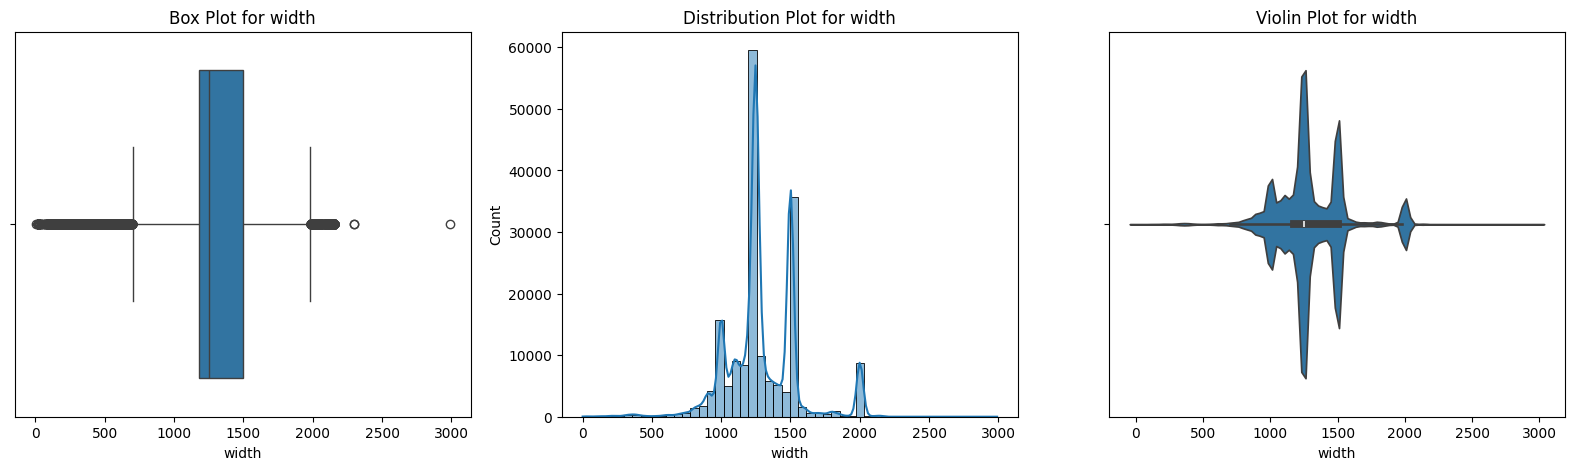

Skewness for product_ref is 1.015043649374606


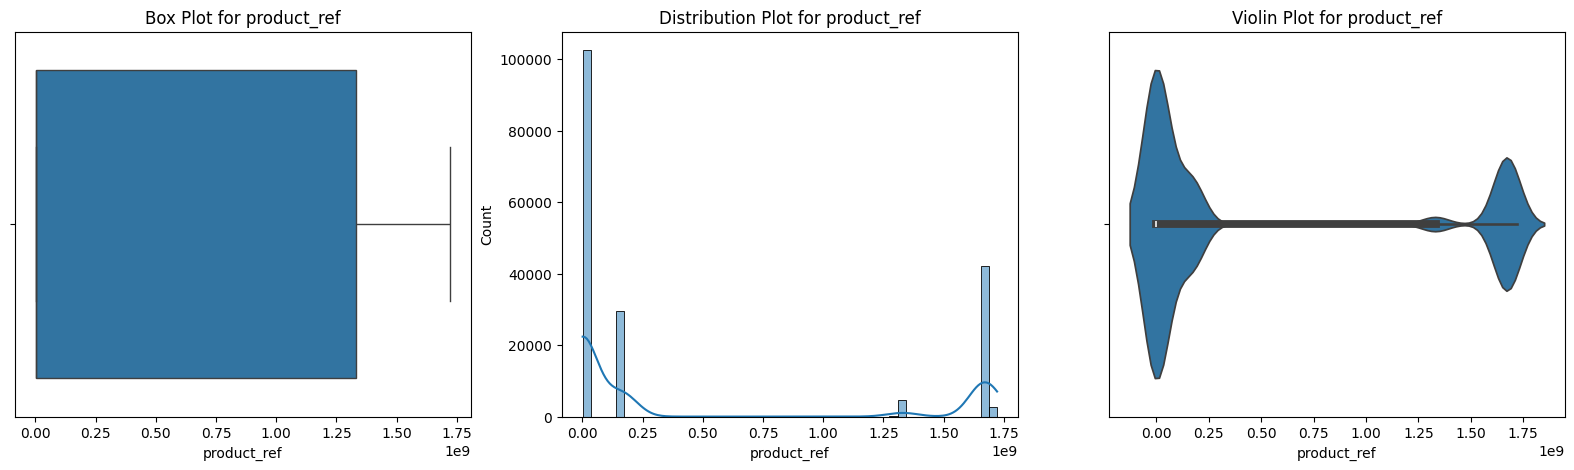

Skewness for log_selling_price is -5.342799354887634


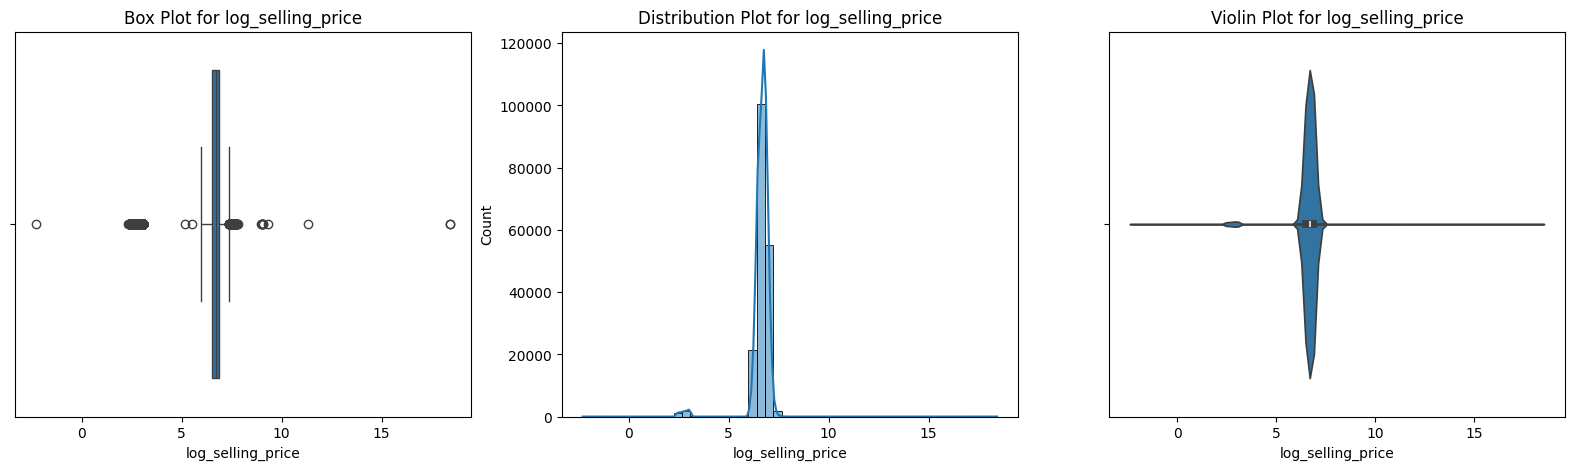

In [27]:
## Checking outliers after treated with log transformation
a = ["log_quantity_tons","customer","country","application","log_thickness","width","product_ref","log_selling_price"]


for i in a:
    print(f"Skewness for {i} is {df[i].skew()}")
    plot(df, i)

## Now checking the Statistical analysis for columns with Selling price

In [28]:
df.head(2)

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,ztb_tons,log_quantity_tons,log_selling_price,log_thickness
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0,-0.002478,3.991779,6.749931,0.693147
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.8,1210.0,S0380700,1668701718,2021-04-01,1047.0,-0.002174,6.643822,6.953684,-0.223144


### Shapiro test tell mathematically whether the data is distributed normally or not

In [29]:
## Checking whether th columns are Normally distributed

for i in df.columns:
    if (df[i].dtype == 'float64') | (df[i].dtype == 'int64'):
        print("shapario test for "f'{i}',stats.shapiro(df[i]))  

shapario test for quantity tons ShapiroResult(statistic=0.00013531300090929843, pvalue=3.0811817871636014e-201)
shapario test for customer ShapiroResult(statistic=0.44600414415196443, pvalue=6.1698499104801344e-180)
shapario test for country ShapiroResult(statistic=0.6974795427381625, pvalue=2.3344028042315295e-159)
shapario test for application ShapiroResult(statistic=0.7992029376085136, pvalue=3.8952320012399153e-146)
shapario test for thickness ShapiroResult(statistic=0.6477514545524956, pvalue=2.0455116336593096e-164)
shapario test for width ShapiroResult(statistic=0.9174606923869836, pvalue=1.900567101576535e-119)
shapario test for product_ref ShapiroResult(statistic=0.6096056685689504, pvalue=7.05864227459483e-168)
shapario test for selling_price ShapiroResult(statistic=0.0002462650549330814, pvalue=3.1105263606649025e-201)
shapario test for ztb_tons ShapiroResult(statistic=0.00013531300090952048, pvalue=3.0811817871636014e-201)
shapario test for log_quantity_tons ShapiroResult(s

C:\Users\nisha\AppData\Local\Temp\ipykernel_2336\1411071623.py:5: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 181620.
  print("shapario test for "f'{i}',stats.shapiro(df[i]))


In [30]:
## Checking for column dependency. 
ztest(df["width"],df["selling_price"],value=0)  ## Fail to reject. Hence independent data no difference

(-0.8003659428466533, 0.4234988071006005)

In [31]:
a_1 = df[df["thickness"] == 01.0]["selling_price"]
a_2 = df[df["thickness"] == 2.0]["selling_price"]
a_3 = df[df["thickness"] == 3.0]["selling_price"]
a_1_50 = df[df["thickness"] == 1.50]["selling_price"]
a_0_50 = df[df["thickness"] == 0.50]["selling_price"]

print(ztest(a_1,df["selling_price"],value=0))   ## All the below shows it is independent. So need to do wilconson test
print(ztest(a_2,df["selling_price"],value=0))
print(ztest(a_3,df["selling_price"],value=0))
print(ztest(a_1_50,df["selling_price"],value=0))
print(ztest(a_0_50,df["selling_price"],value=0))


(-0.3158922078433192, 0.7520843265675486)
(-0.40418610449849113, 0.6860758710991492)
(-0.4078532703973127, 0.683381401663262)
(-0.3658169757690939, 0.7145016517700615)
(-0.31686155134461397, 0.7513486574223155)


## Heat Map check for highly correlated columns

<Axes: >

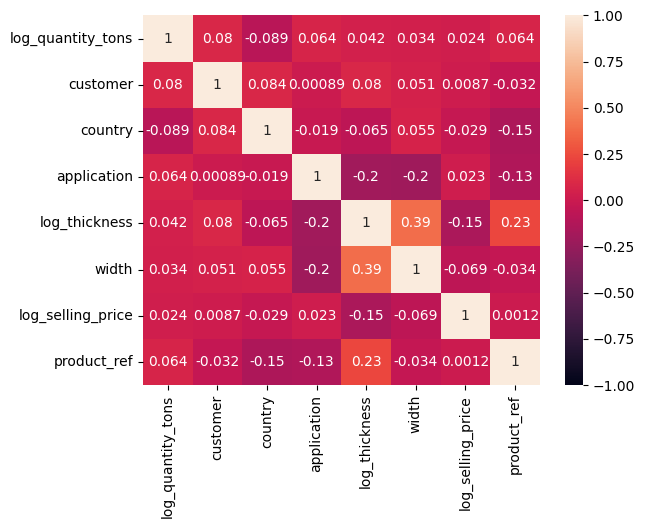

In [33]:
# Need to verify any columns are highly correlated using Heatmap. If any columns correalaion value >= 0.7 (absolute value),
# then drop the columns.

a = df[['log_quantity_tons', 'customer', 'country', 'application','log_thickness', 'width', 'log_selling_price','product_ref']]

sns.heatmap(a.corr(),annot=True,vmin=-1)
## 0.70 more than absolute value. so drop the columns

# Regression model for Selling_Price prediction

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [35]:
print(df.shape)
df.head(3)

(181620, 17)


,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,ztb_tons,log_quantity_tons,log_selling_price,log_thickness
0,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.00,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.00,-0.002478,3.991779,6.749931,0.693147
1,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.80,1210.0,S0380700,1668701718,2021-04-01,1047.00,-0.002174,6.643822,6.953684,-0.223144
2,2021-04-01,386.127949,30153963.0,30.0,Won,WI,28.0,0.38,952.0,S0380700,628377,2021-01-01,644.33,-0.002337,5.956169,6.468211,-0.967584


In [36]:
df["country"] = df["country"].astype(int)
df["customer"] = df["customer"].astype(int)
df["application"] = df["application"].astype(int)

In [37]:
print(df.status.value_counts(), df["item type"].value_counts())

status
Won                115996
Lost                34431
Not lost for AM     19566
Revised              4276
To be approved       4167
Draft                3120
Offered                53
Offerable              10
Wonderful               1
Name: count, dtype: int64 item type
W         105599
S          69200
PL          5659
Others       610
WI           524
IPL           27
SLAWR          1
Name: count, dtype: int64


In [38]:
df1 = df.copy()

## Converting the categorical data to numerical
item_type_dict = {'W':5.0, 'WI':6.0, 'S':3.0, 'Others':1.0, 'PL':2.0, 'IPL':0.0, 'SLAWR':4.0}

status_dict = {'Lost':0, 'Won':1, 'Draft':2, 'To be approved':3, 'Not lost for AM':4,
            'Wonderful':5, 'Revised':6, 'Offered':7, 'Offerable':8}

df1["status"] = df1["status"].map(status_dict)
df1["item type"] = df1["item type"].map(item_type_dict)

df1.head(2)

,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,ztb_tons,log_quantity_tons,log_selling_price,log_thickness
0,2021-04-01,54.151139,30156308,28,1,5.0,10,2.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0,-0.002478,3.991779,6.749931,0.693147
1,2021-04-01,768.024839,30202938,25,1,5.0,41,0.8,1210.0,S0380700,1668701718,2021-04-01,1047.0,-0.002174,6.643822,6.953684,-0.223144


In [39]:
df2 = df1.copy()
## Checking inconsistent data for Date value. where delivery date cannot be less than item date. which may be wrong data
df2.drop(df2[df2["delivery date"] < df2["item_date"]].index,axis=0,inplace=True)
df2.drop(["item_date","quantity tons","thickness","delivery date","selling_price","ztb_tons"],axis=1,inplace=True)

In [40]:
df2.shape

(165515, 11)

In [41]:
df2.head(2)

,customer,country,status,item type,application,width,material_ref,product_ref,log_quantity_tons,log_selling_price,log_thickness
0,30156308,28,1,5.0,10,1500.0,DEQ1 S460MC,1670798778,3.991779,6.749931,0.693147
1,30202938,25,1,5.0,41,1210.0,S0380700,1668701718,6.643822,6.953684,-0.223144


In [46]:
## Converting the categorical data to numerical for material_ref
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df2["material_ref"] = le.fit_transform(df2["material_ref"])

In [47]:
x = df2.drop(["log_selling_price"],axis=1)
y = df2["log_selling_price"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.fit_transform(X_test)

    # from sklearn import metrics
    # print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    # print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    # print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

def accuracy(regg,model):
    from sklearn.metrics import r2_score
    r2 = r2_score(y_test, y_pred)
    print(f'{regg.__name__} R² score:', r2)
    print(f"{regg.__name__} Training data accuracy: ",model.score(X_train,y_train))
    print(f"{regg.__name__} Testing data accuracy: ",model.score(X_test,y_test))
    print(" ")


### Linear Regression model

In [48]:
reg_model = LinearRegression().fit(X_train,y_train)
y_pred = reg_model.predict(X_test)
accuracy(LinearRegression,reg_model)

LinearRegression R² score: 0.03259504155672732
LinearRegression Training data accuracy:  0.0307103571807944
LinearRegression Testing data accuracy:  0.03259504155672732
 


### KNN regression model

In [50]:
KNN_model = KNeighborsRegressor(n_neighbors=5).fit(X_train,y_train)
y_pred = KNN_model.predict(X_test)
accuracy(KNeighborsRegressor,KNN_model)

KNeighborsRegressor R² score: 0.7751412664514868
KNeighborsRegressor Training data accuracy:  0.8593071763097783
KNeighborsRegressor Testing data accuracy:  0.7751412664514868
 


### Decision Tree regression model

In [51]:
DCT_model = DecisionTreeRegressor(max_depth=4).fit(X_train,y_train)
y_pred = DCT_model.predict(X_test)
accuracy(DecisionTreeRegressor,DCT_model)

DecisionTreeRegressor R² score: 0.7425511597132792
DecisionTreeRegressor Training data accuracy:  0.8767067833585396
DecisionTreeRegressor Testing data accuracy:  0.7425511597132792
 


#### With Decision Tree model using Gridsearch CV for hyper paramter tuning to check the best fit parameters

In [52]:
## With Decission tree using the Grid searchCV to determine best hyper parameters parameters

params = {'max_depth'      : [2, 4, 6, 15, 20],
          'min_samples_split': [2, 4, 6, 8, 10, 20],
          'min_samples_leaf' : [1, 2, 3, 4, 6, 8, 16],
          'max_features'     : ['sqrt', 'log2', None]}

dtr = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=dtr, param_grid=params, cv=5)
grid_search.fit(X_train,y_train)
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}


In [53]:
## Getting the below parms stating best fit for the model to produce better accuracy
print("Best hyperparameters:", grid_search.best_params_)
DCT_best_model = grid_search.best_estimator_.fit(X_train,y_train)
# DCT_best_model = grid_search.best_estimator_.fit(X_train,y_train)
y_pred = DCT_best_model.predict(X_test)
accuracy(DecisionTreeRegressor,DCT_best_model)


Best hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 20}
DecisionTreeRegressor R² score: 0.6943979049371166
DecisionTreeRegressor Training data accuracy:  0.9565491315094877
DecisionTreeRegressor Testing data accuracy:  0.6943979049371166
 


### Random forest regressor

In [54]:
## Randomforest Regressor

RFG_best_model = RandomForestRegressor(n_estimators=100,max_depth=20, min_samples_leaf=16, min_samples_split=10, max_features=None).fit(X_train, y_train)
y_pred = RFG_best_model.predict(X_test)
accuracy(RandomForestRegressor,RFG_best_model)


RandomForestRegressor R² score: 0.7518758970564059
RandomForestRegressor Training data accuracy:  0.9430002988934866
RandomForestRegressor Testing data accuracy:  0.7518758970564059
 


#### Finding the Feature importance with RANDOMFOREST technique

In [55]:
## To check the feature importance of each column
x = df2.drop(["log_selling_price"],axis=1)
y = df2["log_selling_price"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

clf = RandomForestRegressor(n_estimators=100,random_state=38)
clf.fit(X_train, y_train)
feature_scores = pd.Series(clf.feature_importances_, index =X_train.columns).sort_values(ascending=False)

In [56]:
feature_scores

status               0.814696
product_ref          0.068256
log_quantity_tons    0.028204
material_ref         0.028094
customer             0.020190
log_thickness        0.013233
country              0.010158
width                0.008374
application          0.005094
item type            0.003701
dtype: float64

#### using the Feature importance with Randomforest techinque to reduce the overfitting and to give better accuracy

In [57]:
# Randomforest Regressor appyling the most important feature to get the best accuracy

## I included all inputs apart from selling price which dropped the accuracy to 74%
## I tried including "Product reference which is dropping the acuracy to 75% hence dropping that feature"
## Inclduing mateetial reference it is giving 1% more accuracy


x = df2[["status","log_quantity_tons","log_thickness","width","country","item type","application"]]
y = df2["log_selling_price"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.fit_transform(X_test)

RFG_best_model = RandomForestRegressor(n_estimators=100,max_depth=20, min_samples_leaf=4, min_samples_split=10, max_features=None,random_state=42).fit(X_train, y_train)
y_pred = RFG_best_model.predict(X_test)
accuracy(RandomForestRegressor,RFG_best_model)


RandomForestRegressor R² score: 0.9071579580906759
RandomForestRegressor Training data accuracy:  0.9373037204228712
RandomForestRegressor Testing data accuracy:  0.9071579580906759
 


### Building the trainned regressor model

In [59]:
# save the regression model by using pickle
import pickle
with open('regression_modelfn.pkl', 'wb') as f:
    pickle.dump(RFG_best_model, f)

#### Calling the model

In [60]:
with open('regression_modelfn.pkl', 'rb') as f:
    regg = pickle.load(f)

#### Predicting the Selling price with the built model

In [61]:
## Model
a = regg.predict([[1,5.4,0.69,1250.0,28.0,5.0,10.0]])
print(a)
print("With 90% accuracy expected selling price is:",np.exp(a[0]))

# Classification prediction for Status

In [62]:
df3 = df2.copy()
df3.head(2)

,customer,country,status,item type,application,width,material_ref,product_ref,log_quantity_tons,log_selling_price,log_thickness
0,30156308,28,1,5.0,10,1500.0,5172,1670798778,3.991779,6.749931,0.693147
1,30202938,25,1,5.0,41,1210.0,9329,1668701718,6.643822,6.953684,-0.223144


In [63]:
df3.status.value_counts()

status
1    101971
0     33802
4     18823
6      4070
3      4064
2      2722
7        53
8         9
5         1
Name: count, dtype: int64

#### As per the requirement dropping the other status cloumns other than WON and LOST

In [64]:
## We need only the status of Lost and Won
##status_dict = {'Lost':0, 'Won':1}

df3.drop(df3[~((df3["status"] == 1) | (df3["status"] == 0))].index,axis=0,inplace=True)

In [65]:
# df_1 = df3[df3["status"] == 1].sample(60000)
# df_0 = df3[df3["status"] == 0]
# df5 = pd.concat([df_1,df_0])
# df5.status.value_counts()

### Function defined with standard set to be used in all classifiers

In [66]:
def classification_algo():
    global X_train, X_test, y_train, y_test
    x = df3.drop(["status","material_ref"],axis=1)
    y = df3["status"]

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, stratify=y, random_state=42)

    from sklearn.preprocessing import StandardScaler
    SS = StandardScaler()
    X_train = SS.fit_transform(X_train)
    X_test = SS.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

#### Doing Smote for Oversampling technique. which will duplicate and add where there is less data

In [143]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek

def classification_algo1():
    global X_train, X_test, y_train, y_test
    x = df3.drop(["status"],axis=1)
    y = df3["status"]

    print(x.shape)
    print(y.shape)

    x_new, y_new = SMOTE().fit_resample(x,y)

    x_new.value_counts()
    y_new.value_counts()

    print(x_new.shape)
    print(y_new.shape)

    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=42)

    from sklearn.preprocessing import StandardScaler
    SS = StandardScaler()
    X_train = SS.fit_transform(X_train)
    X_test = SS.fit_transform(X_test)

    return X_train, X_test, y_train, y_test

### Logistic Regression as Classifier

In [68]:
from sklearn.linear_model import LogisticRegression

classification_algo1()
log_model = LogisticRegression(max_iter=1000).fit(X_train,y_train)
y_pred = log_model.predict(X_test)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))
pd.crosstab(y_test,y_pred)

(135773, 10)
(135773,)
(203942, 10)
(203942,)
              precision    recall  f1-score   support

           0       0.68      0.69      0.68     30696
           1       0.68      0.67      0.67     30487

    accuracy                           0.68     61183
   macro avg       0.68      0.68      0.68     61183
weighted avg       0.68      0.68      0.68     61183



col_0,0,1
status,,
0,21116,9580
1,10153,20334


#### Adjusting the threshold to get better accuracy

In [69]:
def predict_threshold (model,X_test,thresholds):
    import numpy as np
    return np.where(model.predict_proba(X_test)[:,1]>thresholds,1,0) #

In [70]:
## from the above it Clearly shows the crosstab has some errors. as well the accuracy is not good. 
##So in this case we are going for threshhold adjustments to get better accuracy

log_model.predict_proba(X_test)

y_predict_th3 = np.where(log_model.predict_proba(X_test)[:,1]>0.5,1,0) # 

print("Logistic regression accuracy_score",accuracy_score(y_test,y_predict_th3))
print(classification_report(y_test,y_pred))
pd.crosstab(y_test,y_predict_th3)

Logistic regression accuracy_score 0.6774757694130723
              precision    recall  f1-score   support

           0       0.68      0.69      0.68     30696
           1       0.68      0.67      0.67     30487

    accuracy                           0.68     61183
   macro avg       0.68      0.68      0.68     61183
weighted avg       0.68      0.68      0.68     61183



col_0,0,1
status,,
0,21116,9580
1,10153,20334


In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix
for thr in np.arange(0.5,0.6,0.01):
   y_predict = predict_threshold(log_model,X_test,thr)
   print("Threshold :",thr)
   print(confusion_matrix(y_test,y_predict))

Threshold : 0.5
[[21116  9580]
 [10153 20334]]
Threshold : 0.51
[[21666  9030]
 [10603 19884]]
Threshold : 0.52
[[22183  8513]
 [11069 19418]]


Threshold : 0.53
[[22655  8041]
 [11519 18968]]
Threshold : 0.54
[[23111  7585]
 [11971 18516]]
Threshold : 0.55
[[23586  7110]
 [12435 18052]]
Threshold : 0.56
[[24044  6652]
 [12927 17560]]
Threshold : 0.5700000000000001
[[24485  6211]
 [13410 17077]]
Threshold : 0.5800000000000001
[[24880  5816]
 [13917 16570]]
Threshold : 0.5900000000000001
[[25275  5421]
 [14447 16040]]


In [72]:
## from the threhsold adjustment found that the below is having better accuracy by covering all factors
log_model.predict_proba(X_test)

y_predict_th3 = np.where(log_model.predict_proba(X_test)[:,1]>0.5,1,0) # 

print(classification_report(y_test,y_predict_th3))
pd.crosstab(y_test,y_predict_th3)

              precision    recall  f1-score   support

           0       0.68      0.69      0.68     30696
           1       0.68      0.67      0.67     30487

    accuracy                           0.68     61183
   macro avg       0.68      0.68      0.68     61183
weighted avg       0.68      0.68      0.68     61183



col_0,0,1
status,,
0,21116,9580
1,10153,20334


## KNN classifier 

In [156]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

classification_algo1()
k=2
Knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
y_pred = Knn_model.predict(X_test)
y_pred_train = Knn_model.predict(X_train)
print(f"When K value is :{k}, Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"When K value is :{k}, Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :2, Accuracy score of training data :0.9516948143374498
When K value is :2, Accuracy score of testing data :0.84494058807185
 
              precision    recall  f1-score   support

           0       0.81      0.91      0.85     30696
           1       0.90      0.78      0.83     30487

    accuracy                           0.84     61183
   macro avg       0.85      0.84      0.84     61183
weighted avg       0.85      0.84      0.84     61183



#### Finding which K-Value gives better accuracy 

In [140]:
# For Euclidian distance finding best k-value
for k in range(1,20):
    classification_algo1()
    Knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
    y_hat = Knn_model.predict(X_test)
    print(f"When K value is :{k}, Accuracy score is :{accuracy_score(y_test,y_hat)}")

(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :1, Accuracy score is :0.8380595917166533
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :2, Accuracy score is :0.8715656309759247
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :3, Accuracy score is :0.8912606442966183
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :4, Accuracy score is :0.8881552065116127
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :5, Accuracy score is :0.8887272608404295
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :6, Accuracy score is :0.8461827631858523
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :7, Accuracy score is :0.8821731526731281
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :8, Accuracy score is :0.8743278361636402
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :9, Accuracy score is :0.8735433045126915
(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :1

In [145]:
## Found 3 and 2 but to me meaning full taking 3 giving more accuracy
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

classification_algo1()
k=3
Knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
y_pred = Knn_model.predict(X_test)
y_pred_train = Knn_model.predict(X_train)
print(f"When K value is :{k}, Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"When K value is :{k}, Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_test,y_pred))

(135773, 10)
(135773,)
(203942, 10)
(203942,)
When K value is :3, Accuracy score of training data :0.953137805672497
When K value is :3, Accuracy score of testing data :0.895771701289574
 
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     30696
           1       0.92      0.86      0.89     30487

    accuracy                           0.90     61183
   macro avg       0.90      0.90      0.90     61183
weighted avg       0.90      0.90      0.90     61183



#### Drawing the AUC, ROC curve

0.8956569768531802
Confusion Matrix:
[[28524  2172]
 [ 4205 26282]]


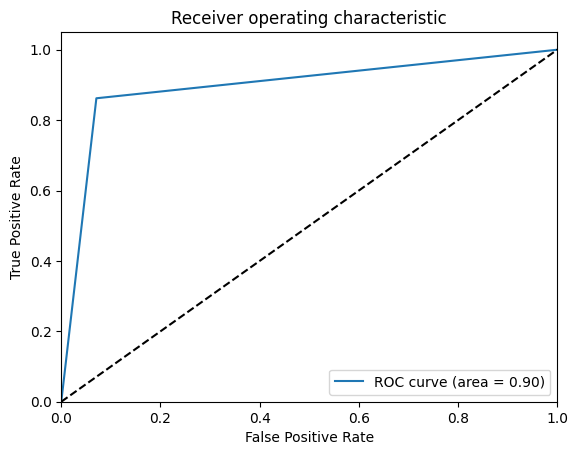

In [146]:
# # Receiver Operating Characteristic (ROC) Curve and Area Under the Curve (AUC)
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
FP,TP,threshold = roc_curve(y_true=y_test, y_score=y_pred)
auc_curve = auc(x=FP, y=TP)
print(auc_curve)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Decission Tree Classifier

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import NearestNeighbors

classification_algo1()
print(X_train.shape)
print(y_train.shape)
## criterion{“gini”, “entropy”, “log_loss”}, default=”gini”
DCT_model = DecisionTreeClassifier(criterion="gini", max_depth = 4).fit(X_train,y_train)
y_pred = DCT_model.predict(X_test)
y_pred_train = DCT_model.predict(X_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")
print(classification_report(y_test,y_pred))

(135773, 10)
(135773,)
(203942, 10)
(203942,)
(142759, 10)
(142759,)
Accuracy score of training data :0.7267843008146597
Accuracy score of testing data :0.698985012176585
 
              precision    recall  f1-score   support

           0       0.73      0.64      0.68     30696
           1       0.68      0.76      0.72     30487

    accuracy                           0.70     61183
   macro avg       0.70      0.70      0.70     61183
weighted avg       0.70      0.70      0.70     61183



#### Using Gridsearch CV to find the best fit parameters for hyper tuning

In [77]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth'      : [2, 4, 6, 8, 10, 12],
          'min_samples_split': [2, 4, 6, 8, 10, 20],
          'min_samples_leaf' : [1, 2, 3, 4, 6, 10, 20],
          'max_features'     : ['sqrt', 'log2', None]}

classification_algo1()
DCTGV_model = DecisionTreeClassifier().fit(X_train,y_train)

GCVDT_model = GridSearchCV(estimator=DCTGV_model, param_grid = params, cv=5).fit(X_train,y_train)
GCVDT_model

(135773, 10)
(135773,)
(203942, 10)
(203942,)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 3, 4, 6, 10, 20],
                         'min_samples_split': [2, 4, 6, 8, 10, 20]})

#### Using the found best hyper parameters in Decision tree classifier

In [78]:
print("Best hyperparameters:", GCVDT_model.best_params_)
classification_algo1()
GCVDT_best_model = GCVDT_model.best_estimator_.fit(X_train,y_train)
y_pred = GCVDT_best_model.predict(X_test)
y_pred_train = GCVDT_best_model.predict(X_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")
print(classification_report(y_test,y_pred))

Best hyperparameters: {'max_depth': 12, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4}
(135773, 10)
(135773,)
(203942, 10)
(203942,)
Accuracy score of training data :0.8687298173845431
Accuracy score of testing data :0.5484203128319958
 
              precision    recall  f1-score   support

           0       0.53      0.90      0.67     30696
           1       0.66      0.19      0.30     30487

    accuracy                           0.55     61183
   macro avg       0.60      0.55      0.48     61183
weighted avg       0.60      0.55      0.48     61183



## RANDOMFOREST CLASSIFIER

(135773, 10)
(135773,)
(203942, 10)
(203942,)
Accuracy score of training data :0.8956773303259339
Accuracy score of testing data :0.7300393900266414
 
              precision    recall  f1-score   support

           0       0.71      0.79      0.75     30696
           1       0.76      0.67      0.71     30487

    accuracy                           0.73     61183
   macro avg       0.73      0.73      0.73     61183
weighted avg       0.73      0.73      0.73     61183



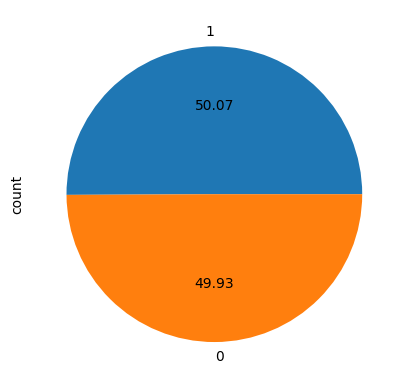

In [79]:
from sklearn.ensemble import RandomForestClassifier
classification_algo1()
RF_best_model = RandomForestClassifier(n_estimators=100,max_depth=12, min_samples_leaf=1, min_samples_split=2, max_features=None).fit(X_train, y_train)
y_pred = RF_best_model.predict(X_test)
y_pred_train = RF_best_model.predict(X_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")
print(classification_report(y_test,y_pred))

ax = y_train.value_counts().plot.pie(autopct='%.2f')

#### Trying to find the best feature importance

In [80]:
from sklearn.ensemble import RandomForestClassifier
x = df3.drop(["status"],axis=1)
y = df3["status"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train, y_train)
feature_scores = pd.Series(clf.feature_importances_, index =X_train.columns).sort_values(ascending=False)

In [81]:
feature_scores

customer             0.152263
log_quantity_tons    0.142661
log_selling_price    0.132628
material_ref         0.127138
country              0.103601
item type            0.085916
application          0.075142
log_thickness        0.071219
product_ref          0.056486
width                0.052947
dtype: float64

## Random Forest technique with Feature importance columns

In [82]:
x = df3[["customer","log_quantity_tons","log_selling_price","material_ref","country","item type"]]
y = df3["status"]

x_new, y_new = SMOTE().fit_resample(x,y)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.3, random_state=42)

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
X_test = SS.fit_transform(X_test)

RF_best_model = RandomForestClassifier(n_estimators=100,max_depth=12, min_samples_leaf=1, min_samples_split=4, max_features=None).fit(X_train, y_train)
y_pred = RF_best_model.predict(X_test)
y_pred_train = RF_best_model.predict(X_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(" ")
print(classification_report(y_test,y_pred))

Accuracy score of training data :0.8806590127417536
Accuracy score of testing data :0.7371492081133648
 
              precision    recall  f1-score   support

           0       0.72      0.77      0.75     30696
           1       0.75      0.70      0.73     30487

    accuracy                           0.74     61183
   macro avg       0.74      0.74      0.74     61183
weighted avg       0.74      0.74      0.74     61183



## Extra Tree Classifier

In [136]:
from sklearn.ensemble import ExtraTreesClassifier
classification_algo1()
clf = ExtraTreesClassifier(n_estimators=200,max_depth=12, min_samples_leaf=1, min_samples_split=2, max_features=None, random_state=42).fit(X_train, y_train)
#clf = ExtraTreesClassifier(n_estimators=200).fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(classification_report(y_test,y_pred))

(135773, 10)
(135773,)
(203942, 10)
(203942,)
Accuracy score of training data :0.8651293438592312
Accuracy score of testing data :0.8241014660935227
              precision    recall  f1-score   support

           0       0.82      0.83      0.83     30696
           1       0.82      0.82      0.82     30487

    accuracy                           0.82     61183
   macro avg       0.82      0.82      0.82     61183
weighted avg       0.82      0.82      0.82     61183



## Gradient Boosting Classifier

In [84]:
from sklearn.ensemble import GradientBoostingClassifier
classification_algo1()
gbc = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.1,random_state = 42).fit(X_train, y_train)
y_pred = gbc.predict(X_test)
y_pred_train = gbc.predict(X_train)

print(f"Accuracy score of training data :{accuracy_score(y_train,y_pred_train)}")
print(f"Accuracy score of testing data :{accuracy_score(y_test,y_pred)}")
print(classification_report(y_test,y_pred))

(135773, 10)
(135773,)
(203942, 10)
(203942,)
Accuracy score of training data :0.7816670052325948
Accuracy score of testing data :0.7133517480345848
              precision    recall  f1-score   support

           0       0.67      0.83      0.74     30696
           1       0.78      0.60      0.68     30487

    accuracy                           0.71     61183
   macro avg       0.72      0.71      0.71     61183
weighted avg       0.72      0.71      0.71     61183



#### saving the trainned model(KNN in this case)

In [147]:
# save the classification model by using pickle
import pickle
with open('classification_modelfn.pkl', 'wb') as f:
    pickle.dump(Knn_model, f)

#### Calling the saved model to predict

In [148]:
with open('classification_modelfn.pkl', 'rb') as f:
    class1 = pickle.load(f)

In [149]:
# df3['customer', 'country', 'item type', 'application', 'width',
#        'material_ref', 'product_ref', 'log_quantity_tons', 'log_selling_price',
#        'log_thickness']
### Model1

a = class1.predict(np.array([[30156308,28,5.0,10,1500.0,5172,1670798778,np.log(575),np.log(890),np.log(10.0)]]))
print(a)
if a[0] == 1:
    b = "Success"
else:
    b = "Failure"

print("With 89% accuracy the copper status is considered as:",b,":with the materials chosen")

[1]
With 89% accuracy the copper status is considered as: Success :with the materials chosen


### below can be ignored. Below are for testing other samples

In [127]:
material_ref_values = ["DX51D+Z","DC01",'G9010','G9006','G9002','DEQ1 S460MC','S0380700','S0380700','DX51D+ZM310MAO 2.3X1317','2_S275JR+AR-CL1','NBW_L+_A_1125_0.4',
                               'NBW_L+_A_1125_0.4','NBW_L+_1125_0.4','NBW_L+_1125_0.4','NBW_L+_1125_0.4','NBW_L+_1125_0.4','DC04EK','DC04EK',
                               'DC04EK','PEA1265X595SP','PEA1265X595SP','PEA1265X595SP','684Z WHITE ETEX B7032','GRE1265X595SP','GRE1265X595SP']

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
mat = le.fit_transform(material_ref_values)
mat

array([ 5,  2,  9,  8,  7,  4, 14, 14,  6,  0, 12, 12, 11, 11, 11, 11,  3,
        3,  3, 13, 13, 13,  1, 10, 10], dtype=int64)

In [134]:
material_ref_values = "DEQ1 S460MC"
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
mat = le.fit_transform([material_ref_values])
mat[0]

0

In [126]:
mat

array([ 5,  2,  9,  8,  7,  4, 14, 14,  6,  0, 12, 12, 11, 11, 11, 11,  3,
        3,  3, 13, 13, 13,  1, 10, 10], dtype=int64)

In [116]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
z  = "DX51D+Z"
mat = le.fit_transform([z])


In [121]:
mat[0]

0

In [115]:
a = class1.predict([[30156308,28,5.0,10,1500.0,5172,1670798778,np.log(575),np.log(890),np.log(10.0)]])

from sklearn.preprocessing import StandardScaler
SS = StandardScaler()
X_train = SS.fit_transform([a])

print(X_train)

[[0.]]


In [135]:
df3.dtypes

customer               int32
country                int32
status                 int64
item type            float64
application            int32
width                float64
material_ref           int32
product_ref            int64
log_quantity_tons    float64
log_selling_price    float64
log_thickness        float64
dtype: object

In [150]:
# mat = le.fit(["DX51D+Z"])

val = [30156308,28,5.0,10,1500.0,mat[0],1670798778,np.log(575),np.log(890),np.log(10.0)]
# scal_val = SS.fit_transform([val])
# print(scal_val)
# a = class1.predict(scal_val)
a = class1.predict([val])
print(a)
if a[0] == 1:
    b = "Success"
else:
    b = "Failure"

print("With 89% accuracy the copper status is considered as:",b,":with the materials chosen")

[1]
With 89% accuracy the copper status is considered as: Success :with the materials chosen
